In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import scipy.stats
from tqdm import tqdm
from autoencoder_helper import gaussian_1d

seed = 10000
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

load = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class Net(nn.Module):
    
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(n_input,150, bias=False)
        self.enc2 = nn.Linear(150,100, bias=False)
        self.enc3 = nn.Linear(100,50, bias=False)
        self.enc4 = nn.Linear(50,10, bias=False)
        
        # decoder
        self.dec1 = nn.Linear(10, 50, bias=False)
        self.dec2 = nn.Linear(50, 100, bias=False)
        self.dec3 = nn.Linear(100, 150, bias=False)
        self.dec4 = nn.Linear(150, n_output, bias=False)
        
        self.bn_enc1 = nn.BatchNorm1d(150)
        self.bn_enc2 = nn.BatchNorm1d(100)
        self.bn_enc3 = nn.BatchNorm1d(50)
        self.bn_enc4 = nn.BatchNorm1d(10)
        
        self.bn_dec1 = nn.BatchNorm1d(50)
        self.bn_dec2 = nn.BatchNorm1d(100)
        self.bn_dec3 = nn.BatchNorm1d(150)

    def forward(self, x):
        x = self.bn_enc1(torch.relu(self.enc1(x)))
        x = self.bn_enc2(torch.relu(self.enc2(x)))
        x = self.bn_enc3(torch.relu(self.enc3(x)))
        x = self.bn_enc4(torch.relu(self.enc4(x)))
        x = self.bn_dec1(torch.relu(self.dec1(x)))
        x = self.bn_dec2(torch.relu(self.dec2(x)))
        x = self.bn_dec3(torch.relu(self.dec3(x)))
        x = self.dec4(x)
        return x

In [3]:
#generate training data of uni and bimodal Gaussians

n_input = 200
n_output = n_input # n_output == n_input for autoencoders

n_train_data = 20000
n_test_data = 2000
train_data = np.empty((0,n_input), float)
test_data = np.empty((0,n_input), float)

for i in tqdm(range(n_train_data)):
    
    # unimodal 2d train data
    mean = np.random.uniform(-10,10, size=2)
    cov = np.eye(2)
    cov[0,0] = np.random.uniform(1,2)
    cov[1,1] = np.random.uniform(1,2)
    data = np.random.multivariate_normal(mean, cov, size=100)
#     sortidxs = np.argsort(np.linalg.norm(data, axis=1))
#     data = data[sortidxs]
    means =  np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    data = np.divide(data - means, stds)
    data = data.reshape(1,-1)
    train_data = np.append(train_data, data, axis=0)

    # unimodal 2d test data
for i in tqdm(range(n_test_data)):
    
    mean = np.random.uniform(-10,10, size=2)
    cov = np.eye(2)
    cov[0,0] = np.random.uniform(1,2)
    cov[1,1] = np.random.uniform(1,2)
    data = np.random.multivariate_normal(mean, cov, size=100)
#     sortidxs = np.argsort(np.linalg.norm(data, axis=1))
#     data = data[sortidxs]
    means =  np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    data = np.divide(data - means,stds)
    data = data.reshape(1,-1)
    test_data = np.append(test_data, data, axis=0)
    
#     #bimodal train data
#     mean1 = random.uniform(-10,10)
#     mean2 = random.uniform(-10,10)
#     std1 = random.uniform(1,3)
#     std2 = random.uniform(1,3)
#     x1 = np.random.normal(mean1, std1, size=(1,n_input//2))
#     x2 = np.random.normal(mean2, std2, size=(1,n_input//2))
#     bi_data1 = np.concatenate([x1,x2], axis =1)
#     train_data = np.append(train_data, bi_data1, axis= 0)
    
#     #bimodal test data
#     mean1 = random.uniform(-10,10)
#     mean2 = random.uniform(-10,10)
#     std1 = random.uniform(1,3)
#     std2 = random.uniform(1,3)
#     x1 = np.random.normal(mean1, std1, size=(1,n_input//2))
#     x2 = np.random.normal(mean2, std2, size=(1,n_input//2))
#     bi_data2 = np.concatenate([x1,x2], axis =1)
#     test_data = np.append(test_data, bi_data2, axis=0)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1939.42it/s]


In [4]:
train_data = train_data.astype(np.float32)
train_data = torch.from_numpy(train_data)
train_data = train_data.to(device)

test_data = test_data.astype(np.float32)
test_data = torch.from_numpy(test_data)
test_data = test_data.to(device)

In [5]:
epochs_end = 20000
epochs_start = 0
# batch_size = 32
# n_batch = n_train_data//batch_size
net = Net(n_input, n_output)
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_func = nn.MSELoss()
net.train()

Net(
  (enc1): Linear(in_features=200, out_features=150, bias=False)
  (enc2): Linear(in_features=150, out_features=100, bias=False)
  (enc3): Linear(in_features=100, out_features=50, bias=False)
  (enc4): Linear(in_features=50, out_features=10, bias=False)
  (dec1): Linear(in_features=10, out_features=50, bias=False)
  (dec2): Linear(in_features=50, out_features=100, bias=False)
  (dec3): Linear(in_features=100, out_features=150, bias=False)
  (dec4): Linear(in_features=150, out_features=200, bias=False)
  (bn_enc1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dec1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dec2): BatchNorm

In [6]:
if load:
    net = Net(n_input, n_output)
    net = net.to(device)
    checkpoint = torch.load('model_ll_dropout_lr_0.001.pt')
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epochs_start = checkpoint['epoch']

In [7]:
# for e in range(epochs_start, epochs_end):

#     print("Current epoch number: {}".format(e))
#     for i in range(n_batch):
#         mini_batch_data = train_data[i*batch_size:(i+1)*batch_size, :]
#         mini_batch_data = mini_batch_data.to(device)
#         prediction = net(mini_batch_data)
#         #loss = likelihood_loss(prediction, i) 
#         loss = loss_func(prediction, mini_batch_data)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     if (e+1) % 10 == 0 :
#         net.eval()
#         train_pred = net(train_data)
#         #loss = likelihood_loss(full_pred, -1, train=False)
#         loss = loss_func(train_pred, train_data)
#         train_loss = loss.item()
        
#         test_pred = net(test_data)
#         #loss = likelihood_loss(full_pred, -1, train=False)
#         loss = loss_func(test_pred, test_data)
#         test_loss = loss.item()
#         net.train()
        
#         print("Epoch {:d}, train loss: {:f}, test loss: {:f}".format(e,train_loss,test_loss))
# #         torch.save({
# #             'epoch': e,
# #             'model_state_dict': net.state_dict(),
# #             'optimizer_state_dict': optimizer.state_dict()
# #         }, 'model.pt')
        


In [8]:
for e in range(epochs_start, epochs_end):

    prediction = net(train_data)
    loss = loss_func(prediction, train_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (e+1) % 100 == 0 :
        net.eval()
        print("Current epoch number: {}".format(e))
        test_pred = net(test_data)
        loss = loss_func(test_pred, test_data)
        test_loss = loss.item()
        
        train_pred = net(train_data)
        loss = loss_func(train_pred, train_data)
        train_loss = loss.item()
        net.train()
        
        print("Epoch {:d}, train loss: {:f}, test loss: {:f}".format(e,train_loss,test_loss))
#         torch.save({
#             'epoch': e,
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'test_loss': test_loss,
#             'train_loss': train_loss
#         }, 'model_mse_dropout_2d_lr_0.001.pt')
        


Current epoch number: 99
Epoch 99, train loss: 0.964662, test loss: 0.989183
Current epoch number: 199
Epoch 199, train loss: 0.952746, test loss: 0.993154
Current epoch number: 299
Epoch 299, train loss: 0.944212, test loss: 1.000580
Current epoch number: 399
Epoch 399, train loss: 0.937804, test loss: 1.008265
Current epoch number: 499
Epoch 499, train loss: 0.932980, test loss: 1.015180
Current epoch number: 599
Epoch 599, train loss: 0.929341, test loss: 1.020618
Current epoch number: 699
Epoch 699, train loss: 0.926662, test loss: 1.025099
Current epoch number: 799
Epoch 799, train loss: 0.924539, test loss: 1.028074
Current epoch number: 899
Epoch 899, train loss: 0.922828, test loss: 1.030975
Current epoch number: 999
Epoch 999, train loss: 0.921561, test loss: 1.033080
Current epoch number: 1099
Epoch 1099, train loss: 0.920443, test loss: 1.034769
Current epoch number: 1199
Epoch 1199, train loss: 0.919515, test loss: 1.036139
Current epoch number: 1299
Epoch 1299, train loss:

Current epoch number: 10299
Epoch 10299, train loss: 0.910441, test loss: 1.053177
Current epoch number: 10399
Epoch 10399, train loss: 0.910296, test loss: 1.053118
Current epoch number: 10499
Epoch 10499, train loss: 0.910467, test loss: 1.053402
Current epoch number: 10599
Epoch 10599, train loss: 0.910314, test loss: 1.053053
Current epoch number: 10699
Epoch 10699, train loss: 0.910315, test loss: 1.053129
Current epoch number: 10799
Epoch 10799, train loss: 0.910292, test loss: 1.053202
Current epoch number: 10899
Epoch 10899, train loss: 0.910370, test loss: 1.053103
Current epoch number: 10999
Epoch 10999, train loss: 0.910285, test loss: 1.053098
Current epoch number: 11099
Epoch 11099, train loss: 0.910301, test loss: 1.053335
Current epoch number: 11199
Epoch 11199, train loss: 0.910289, test loss: 1.053246
Current epoch number: 11299
Epoch 11299, train loss: 0.910317, test loss: 1.053407
Current epoch number: 11399
Epoch 11399, train loss: 0.910233, test loss: 1.053489
Curr

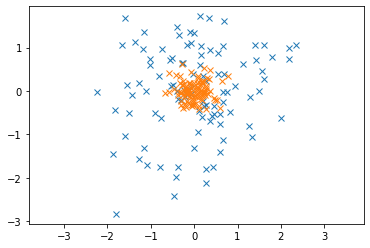

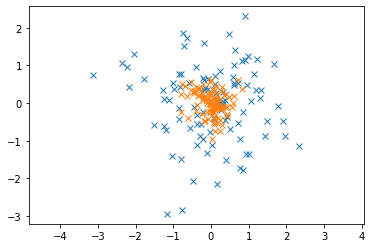

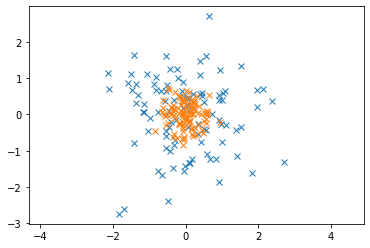

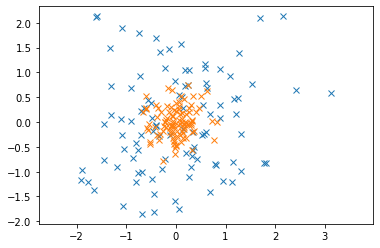

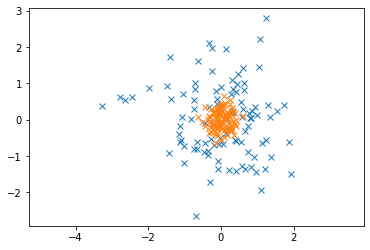

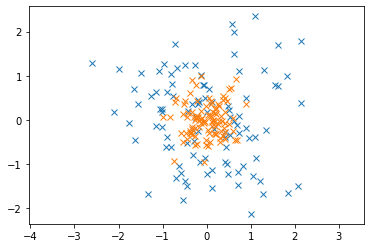

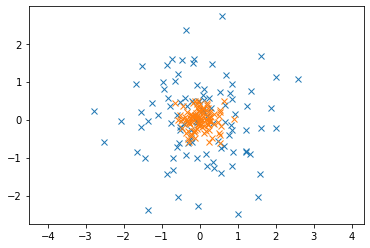

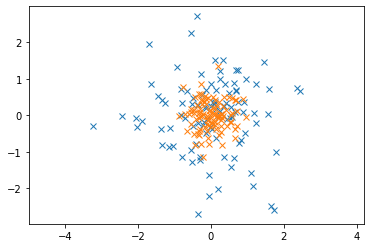

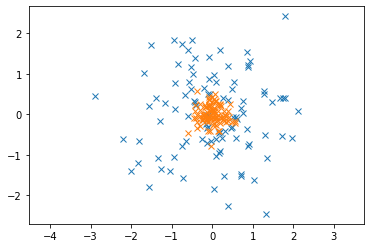

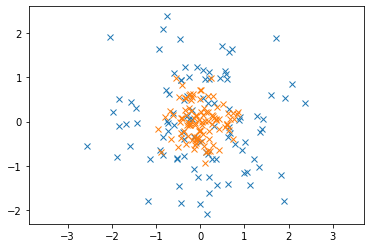

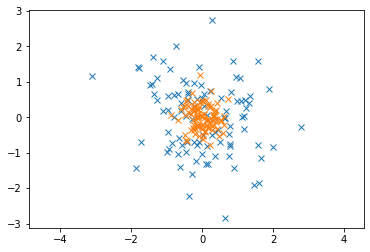

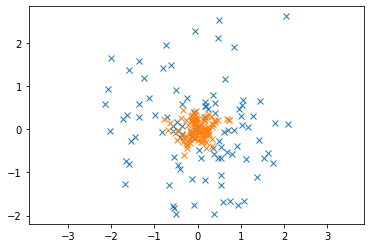

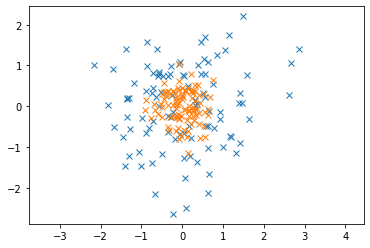

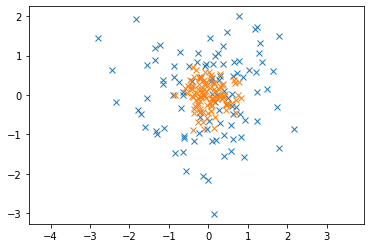

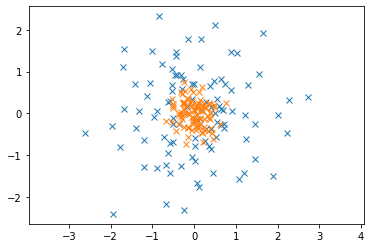

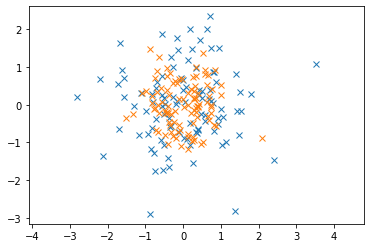

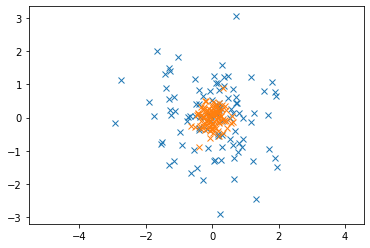

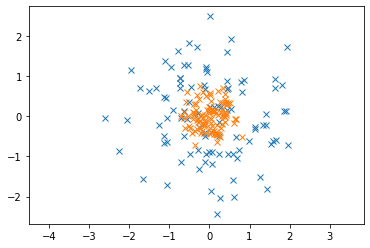

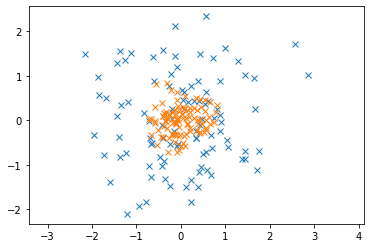

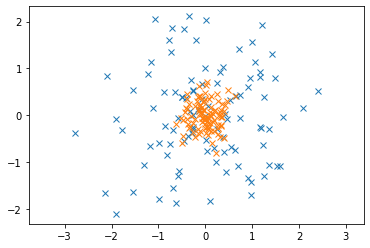

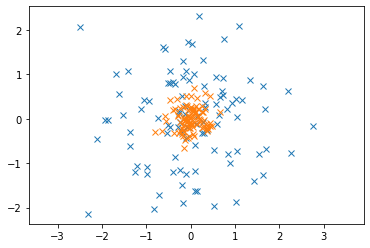

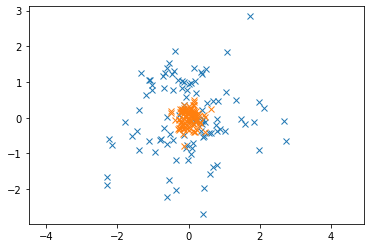

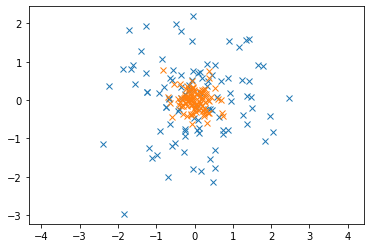

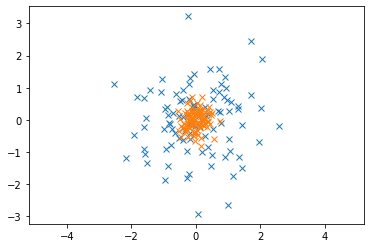

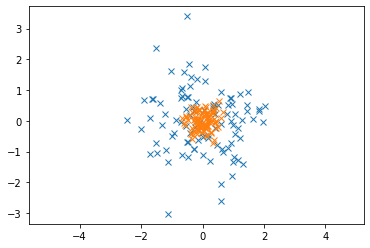

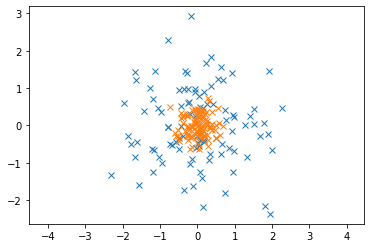

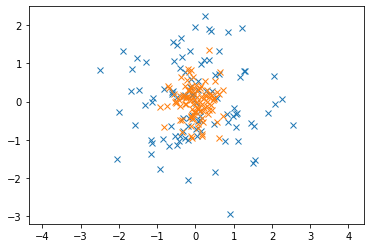

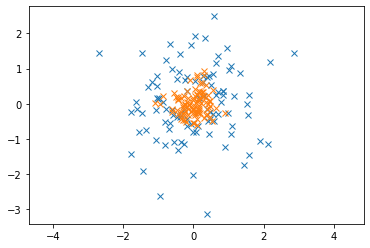

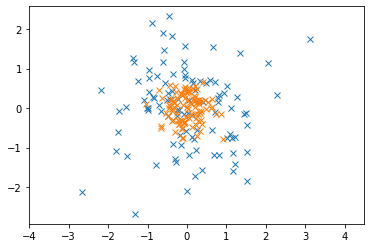

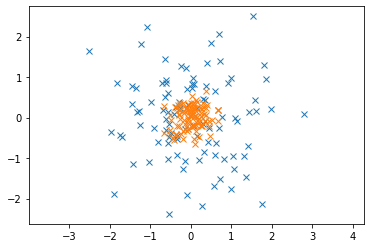

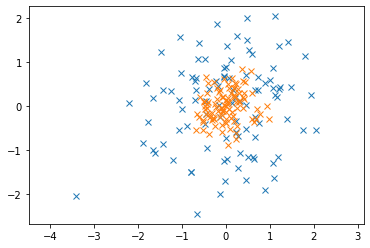

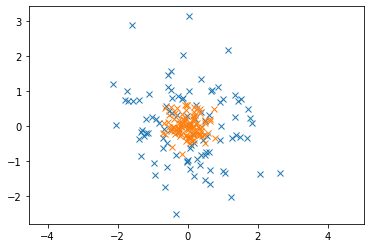

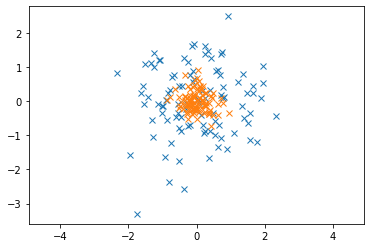

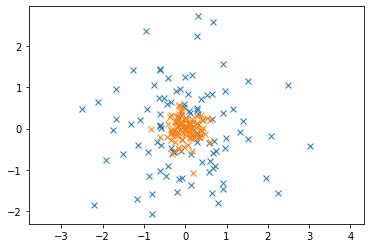

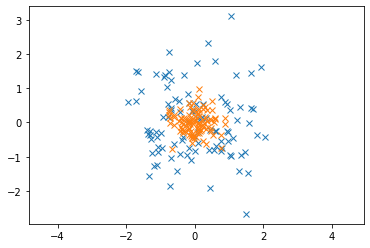

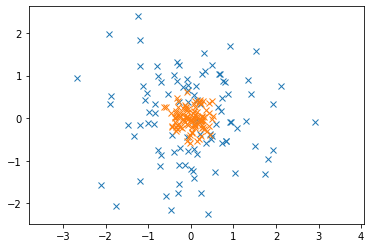

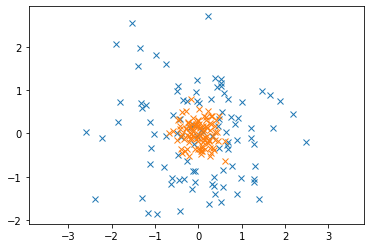

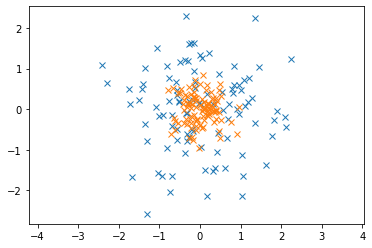

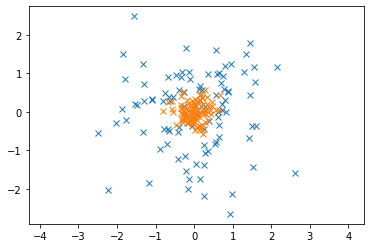

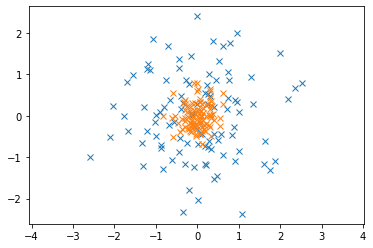

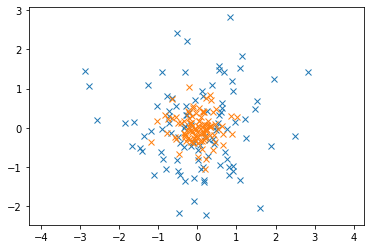

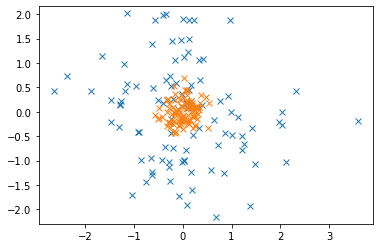

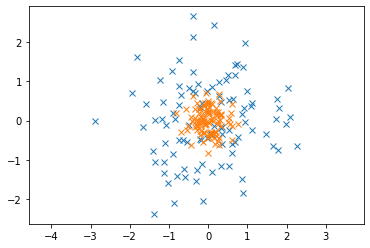

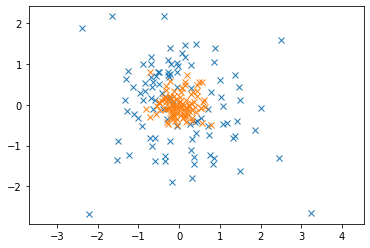

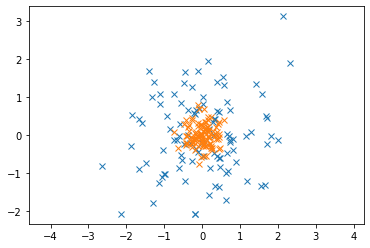

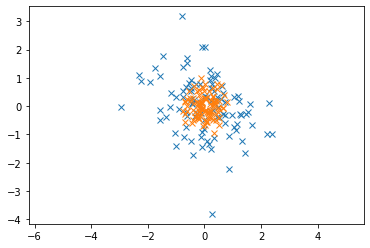

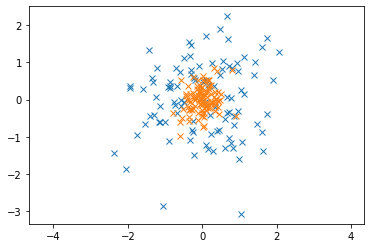

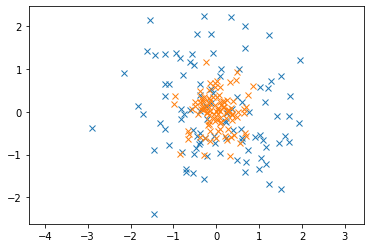

In [9]:
net.eval()
pred = net(test_data)
pred_data = pred.detach().cpu().numpy().reshape(n_test_data,-1,2)
x_pred = pred_data[:,:,0]
y_pred = pred_data[:,:,1]

for i in np.arange(0,1000,21):
    
    x_test, y_test = test_data[i].cpu().numpy().reshape(-1,2).T
    plt.plot(x_test, y_test, 'x')
    plt.plot(x_pred[i], y_pred[i], 'x')
    plt.axis('equal')
    plt.show()

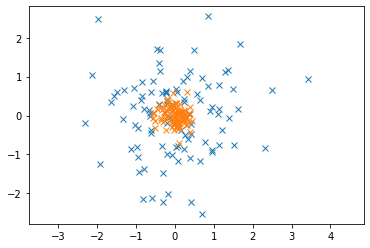

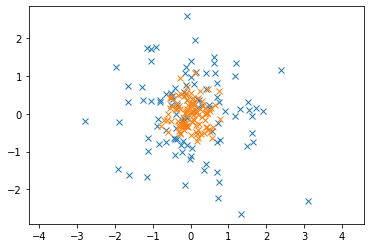

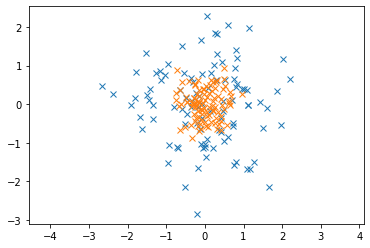

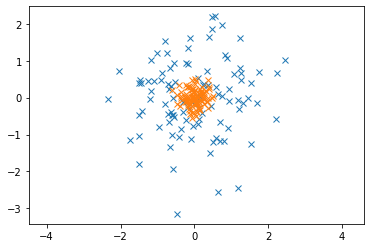

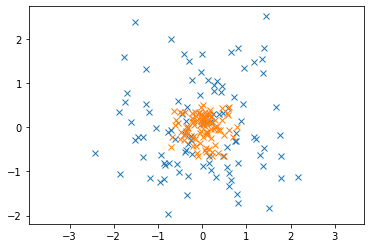

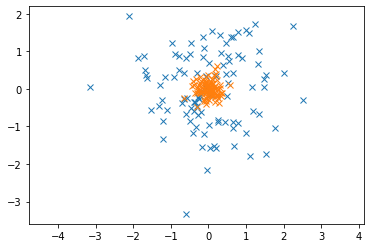

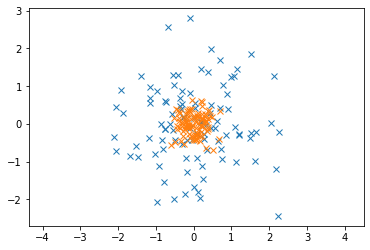

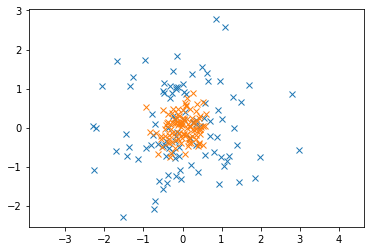

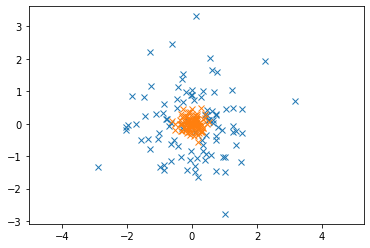

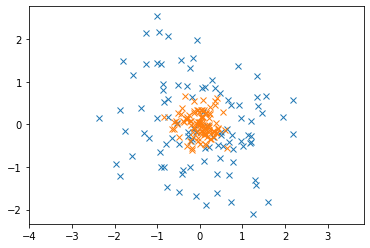

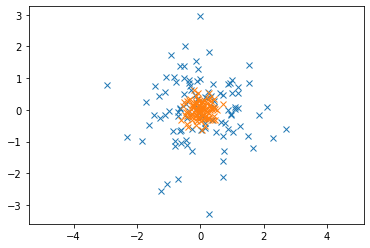

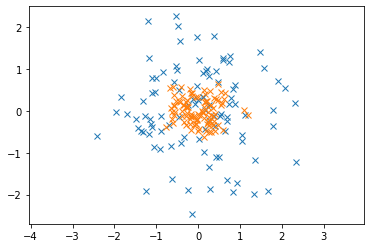

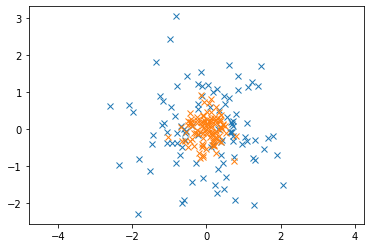

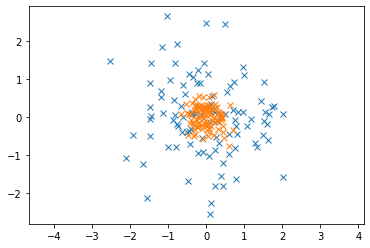

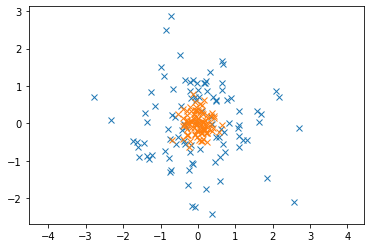

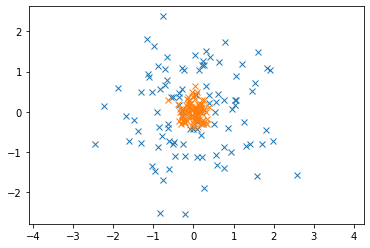

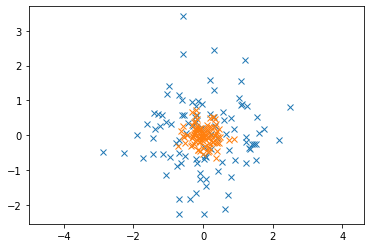

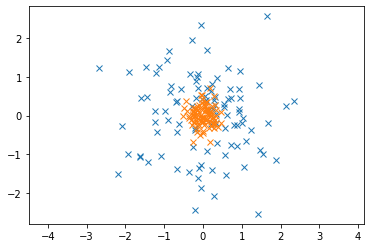

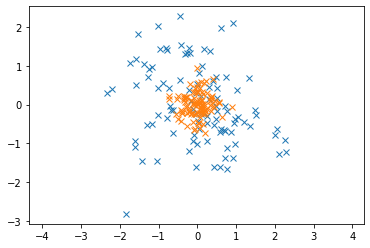

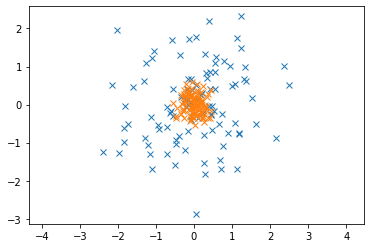

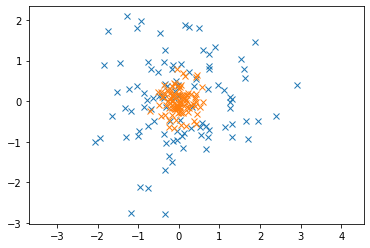

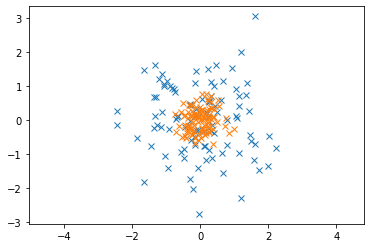

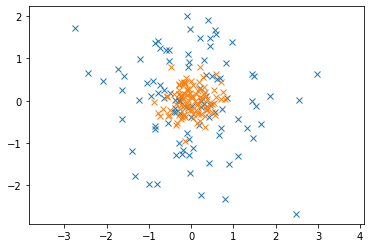

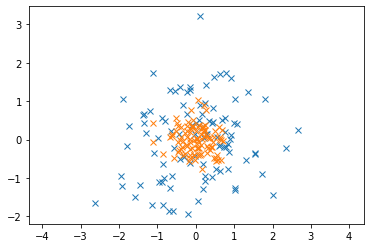

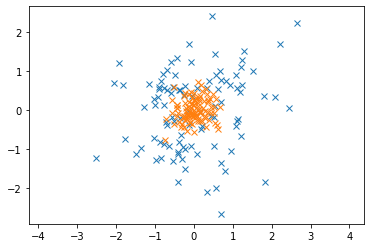

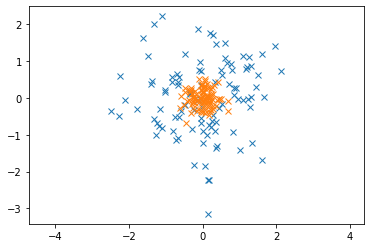

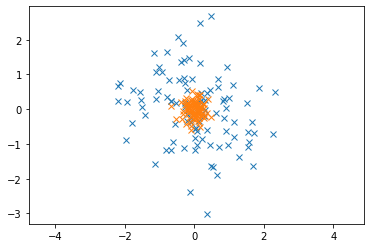

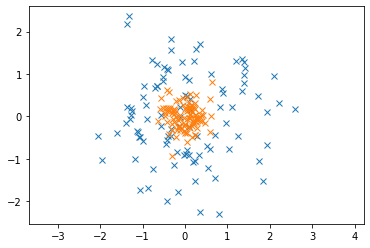

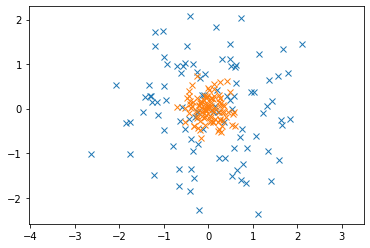

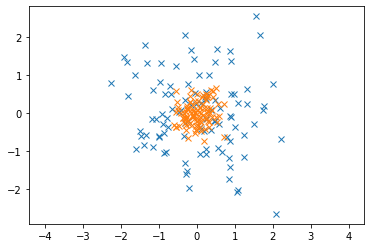

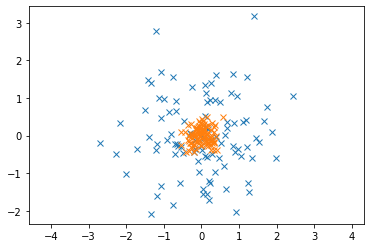

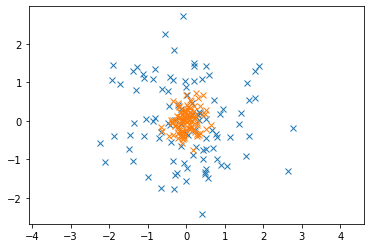

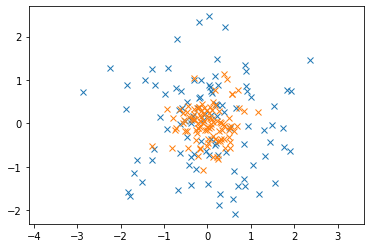

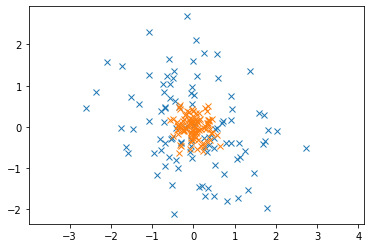

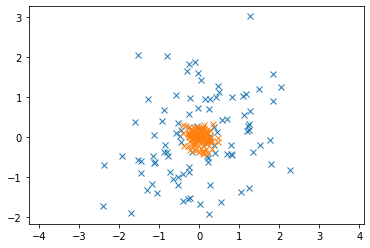

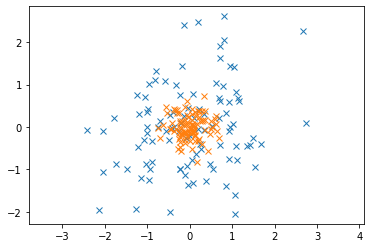

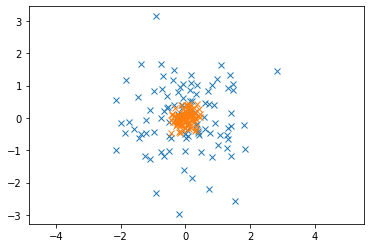

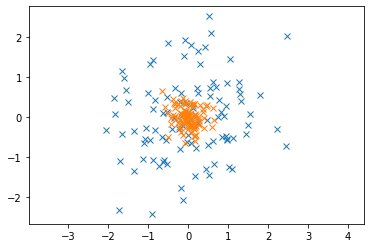

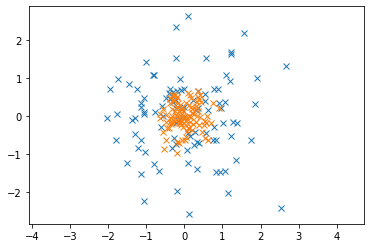

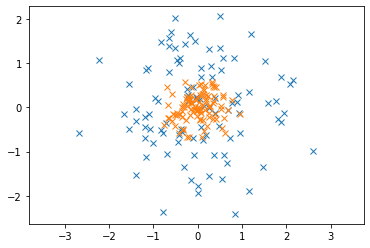

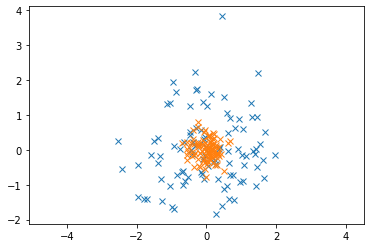

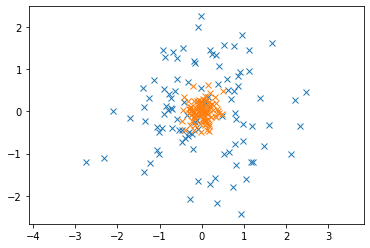

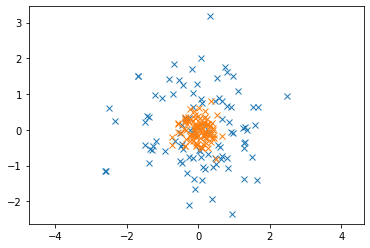

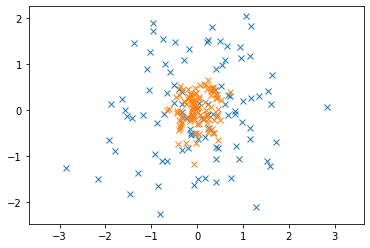

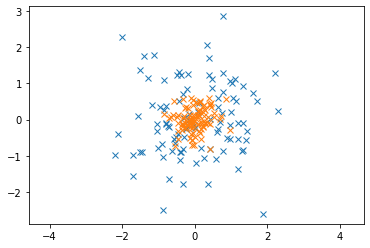

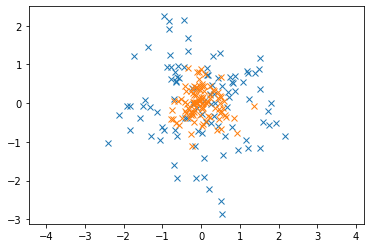

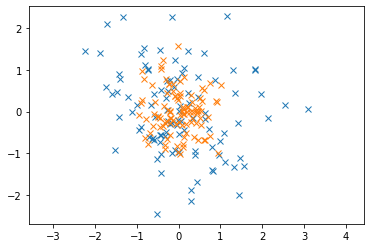

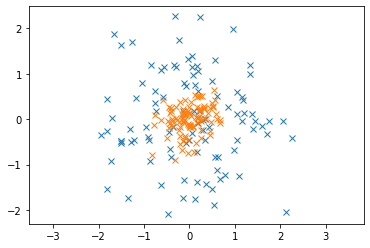

In [10]:
pred = net(train_data)
pred_data = pred.detach().cpu().numpy().reshape(n_train_data,-1,2)
x_pred = pred_data[:,:,0]
y_pred = pred_data[:,:,1]

for i in np.arange(0,1000,21):
    
    x_train, y_train = train_data[i].cpu().numpy().reshape(-1,2).T
    plt.plot(x_train, y_train, 'x')
    plt.plot(x_pred[i], y_pred[i], 'x')
    plt.axis('equal')
    plt.show()